## Data Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sentence_splitter import SentenceSplitter
import matplotlib.pyplot as plt
import os
import ast
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras import backend as K
from focal_loss import SparseCategoricalFocalLoss

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/opt/conda/lib/python3.7/site-packages/sklearn/_distributor_init.py:25: FutureWarning: 
USE_DAAL4PY_SKLEARN variable is deprecated for Intel(R) Extension for Scikit-learn
and will be delete in the 2022.1 release.
Please, use new construction of global patching:
python sklearnex.glob patch_sklearn
Read more: https://intel.github.io/scikit-learn-intelex/global_patching.html
  FutureWarning)
2023-06-01 10:28:10.552893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:28:10.814723: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS 

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-06-01 10:28:20.016837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:28:20.992547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-06-01 10:28:25.637390: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


In [4]:
# data_1 = pd.read_csv("ETD_data.csv")
# data_1['text'] = data_1['text'].astype(str)
# data_1
# train_image = pd.read_csv("trainETD500.csv")
# data_2 = train_image.drop(columns = 'labels')
# data_2
# ETD500 = pd.concat([data_2, data_1], axis = 1)
# ETD500.to_csv('500ETD.csv', encoding = 'utf-8', index=None)
# ack = pd.read_csv('ack.csv')
# ded = pd.read_csv('ded.csv')
# chabs = pd.read_csv('chapter_abs.csv')
# abstract = pd.read_csv('abstract.csv')
# merged = pd.concat([ETD500, ack, ded, chabs, abstract], axis=0)
# merged.set_index('img_path')
# #merged.to_csv('inspect_merged.csv', index = None)

In [5]:
# df500 = pd.read_csv('500ETD_updated.csv')
# df500['text'] = df500['text'].astype(str)
# df500

In [6]:
# df500 = df500[df500['class'] != 'Label-Chapters']
# df500.to_csv("500ETD_chaptersExcluded.csv", encoding = 'utf-8', index = None)
# df500

In [7]:
data = pd.read_csv("500ETD_v2.csv", encoding = 'utf-8')
data['text'] = data['text'].astype(str)
data

,img_path,text,class
0,/home/mchou001/train/1/1.png,'SOME ASPECTS OF RADIATION INDUCED NUCLEATION ...,Label-TitlePage
1,/home/mchou001/train/1/2.png,"'2', 'Dedicated to my', 'parents and sisters'",Label-Dedication
2,/home/mchou001/train/1/3.png,"'3', 'SOME ASPECTS OF RADIATION INDUCED NUCLEA...",Label-Abstract
3,/home/mchou001/train/1/4.png,"'4', 'Acknowledgements', 'I wish to thank fore...",Label-Acknowledgement
4,/home/mchou001/train/1/5.png,"'5', 'Table of Contents', 'Abstract', '3', 'Ac...",Label-TableofContent
...,...,...,...
24760,/home/mchou001/Label-Dedication/502/aug987.png,Dedication\nThe song was reproduced with the p...,Label-Dedication
24761,/home/mchou001/Label-Dedication/502/aug988.png,Dedication\nPermission is required for further...,Label-Dedication
24762,/home/mchou001/Label-Dedication/502/aug989.png,Dedication\nPermission is needed for further r...,Label-Dedication
24763,/home/mchou001/Label-Dedication/502/aug990.png,Dedication\nPermission is required for any fur...,Label-Dedication


In [8]:
label_map = {"Label-Appendices": 0, "Label-ReferenceList": 1, "Label-Other": 2, "Label-TableofContent": 3,  "Label-TitlePage": 4, "Label-Abstract": 5,
             "Label-ListofFigures": 6, "Label-Acknowledgement": 7, "Label-ListofTables": 8, "Label-CurriculumVitae": 9, "Label-Dedication": 10, "Label-ChapterAbstract": 11}

In [9]:
data['label_idx'] = data['class'].apply(lambda x: label_map[x])

In [10]:
data

,img_path,text,class,label_idx
0,/home/mchou001/train/1/1.png,'SOME ASPECTS OF RADIATION INDUCED NUCLEATION ...,Label-TitlePage,4
1,/home/mchou001/train/1/2.png,"'2', 'Dedicated to my', 'parents and sisters'",Label-Dedication,10
2,/home/mchou001/train/1/3.png,"'3', 'SOME ASPECTS OF RADIATION INDUCED NUCLEA...",Label-Abstract,5
3,/home/mchou001/train/1/4.png,"'4', 'Acknowledgements', 'I wish to thank fore...",Label-Acknowledgement,7
4,/home/mchou001/train/1/5.png,"'5', 'Table of Contents', 'Abstract', '3', 'Ac...",Label-TableofContent,3
...,...,...,...,...
24760,/home/mchou001/Label-Dedication/502/aug987.png,Dedication\nThe song was reproduced with the p...,Label-Dedication,10
24761,/home/mchou001/Label-Dedication/502/aug988.png,Dedication\nPermission is required for further...,Label-Dedication,10
24762,/home/mchou001/Label-Dedication/502/aug989.png,Dedication\nPermission is needed for further r...,Label-Dedication,10
24763,/home/mchou001/Label-Dedication/502/aug990.png,Dedication\nPermission is required for any fur...,Label-Dedication,10


## Visualize the data

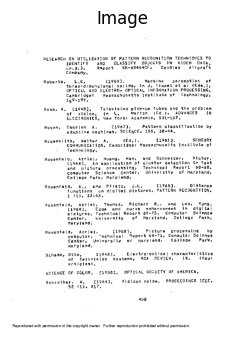

Text:'RESEARCH ON UTILIZATION OF PATTERN RECOGNITION TECHNIQUES TO', 'IDENTIFY AND CLASSIFY OBJECTS IN VIDEO DATA,', 'in.d.] Report SM-48464CF, Dougias Alrcraf', 't', 'Company,', 'Roberts, L.G.', '[1965].', 'Machine perception of', 'three-dimenslonal solids, In J. Tippet et al (Eds.).', 'OPTICAL AND ELECTRO- OPTICAL INFORMATION PROCESSING,', 'Cambridge Massachusetts Institute of Technology,', '159-197', 'Rose, A, Television pick-up tubes and the problem', 'of vision, In L. Marton (Ed.), ADVANCES', 'IN', 'ELECTRONICS, New York: Academic, 131-167,', 'Rosen, Charles A. [1967]. Pattern classiflcatlon by', 'adaptive machines, SCIENCE, 156, 38-44.', 'Rosenbilth, Walter A.', '(Ed.).', '[1961].', 'SENSORY', 'COMMUNICATION, Cambridge: Massachusetts Institute of', 'Technology', 'Rosenfeld, Azriel, Huang, Han, and Schneider, Victor,', '[1968], An application of cluster detection to text', 'and plcture processing, Technical Report 68-68,', 'Computer Sclence Center, Unlversity of Maryland,', 'Colle

In [11]:
%matplotlib inline
def visualize(idx):
    current_row = data.iloc[idx]
    image = cv2.imread(current_row['img_path'])
    text = current_row['text']
    label = current_row['class']
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Image")
    plt.show()
    
    print(f"Text:{text}")
    print(f"Label:{label}")

random_idx = np.random.choice(len(data))
visualize(random_idx)

In [12]:
data['class'].value_counts()

Label-Appendices         8112
Label-ReferenceList      3230
Label-Other              2363
Label-CurriculumVitae    1980
Label-ChapterAbstract    1386
Label-ListofFigures      1171
Label-TableofContent     1120
Label-ListofTables       1110
Label-Abstract           1094
Label-Acknowledgement    1084
Label-Dedication         1069
Label-TitlePage          1046
Name: class, dtype: int64

## Train, Test and Validation set

In [13]:
# 15% for test
train_df, test_df = train_test_split(
    data, test_size=0.15, stratify=data["class"].values, random_state=42
)
# 25% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df["class"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 15787
Total validation examples: 5263
Total test examples: 3715


In [14]:
train_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [15]:
test_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [16]:
val_df.dtypes

img_path     object
text         object
class        object
label_idx     int64
dtype: object

In [17]:
train_df['class'].value_counts()

Label-Appendices         5171
Label-ReferenceList      2059
Label-Other              1507
Label-CurriculumVitae    1262
Label-ChapterAbstract     883
Label-ListofFigures       746
Label-TableofContent      714
Label-ListofTables        708
Label-Abstract            697
Label-Acknowledgement     691
Label-Dedication          682
Label-TitlePage           667
Name: class, dtype: int64

In [18]:
test_df['class'].value_counts()

Label-Appendices         1217
Label-ReferenceList       485
Label-Other               354
Label-CurriculumVitae     297
Label-ChapterAbstract     208
Label-ListofFigures       176
Label-TableofContent      168
Label-ListofTables        166
Label-Abstract            164
Label-Acknowledgement     163
Label-Dedication          160
Label-TitlePage           157
Name: class, dtype: int64

In [19]:
val_df['class'].value_counts()

Label-Appendices         1724
Label-ReferenceList       686
Label-Other               502
Label-CurriculumVitae     421
Label-ChapterAbstract     295
Label-ListofFigures       249
Label-TableofContent      238
Label-ListofTables        236
Label-Abstract            233
Label-Acknowledgement     230
Label-Dedication          227
Label-TitlePage           222
Name: class, dtype: int64

In [20]:
# Define TF Hub paths to the BERT encoder and its preprocessor
#'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3'
    
bert_model_path = (
    'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/2'
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [21]:
def make_bert_preprocessing_model(sentence_features, seq_length=512):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)

In [22]:
bert_preprocess_model = make_bert_preprocessing_model(['text'])
#keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

2023-06-01 10:28:32.518234: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14615 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


## Running the preprocessor on a sample unit

In [23]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text  = row["text"].lower()

print(f"Text: {sample_text}")

Text: '137', 'tagle *xxvii', 'wen-reeponse, 1966 data set', 'number of', 'percentage of total', 'charmeteristic', 'respondents', 'hespondent set', '(a) age of hoad of household', '142', '4.8%', '(b) lonome of housmhold', '221', '7.4', '(c) numbex of chileren', '39', '1.3', '(a) ecucational attainment', '73', '2.4', 'of hand of household', 'la] faca', '119', '4.0', '(f) fead of household', '24', '0.8', '(father, mother, or other}', '[g] eccupation of head of', '107', '3.6', 'houmehold', 'the total respondant eut is comprised of 2973 househalde.', 'pexcentage distributione for the clenentary gchool districts,', 'the esma procedures wege followed fore the 1969 data bat. a table', 'abowing the nisuing deta pattern fbx 1969 za not given becausa it would', 'be neaxly identical to the 1966 pattern in view of the fact that 97 percent', 'of the 1969 population is derived fxom the 1966 population.', 'reproduced with parmission of the copyright owner. further reproduction prohibiled without permi

In [24]:
test_text = [np.array([sample_text])]
text_preprocessed = bert_preprocess_model(test_text)

In [25]:
print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 512)
Word Ids       :  tf.Tensor(
[  101  1005 14989  1005  1010  1005  6415  2571  1008 22038  5737  2072
  1005  1010  1005 19181], shape=(16,), dtype=int32)
Shape Mask     :  (1, 512)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 512)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [26]:
def dataframe_to_dataset(dataframe):
    columns = ["text", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [27]:
#resize = (224, 224)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]

# from keras.preprocessing.image import ImageDataGenerator

# def preprocess_image(image_path):

#     img_path = tf.io.read_file(image_path)
#     image_decode = tf.image.decode_png(img_path, 3)
#     image = tf.image.resize(image_decode, resize)
#     return image


def preprocess_text(text):
    text = tf.convert_to_tensor([text])
    output = bert_preprocess_model([text])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    #image_1 = preprocess_image(sample["img_path"])
    text = preprocess_text(sample["text"])
    return {"text": text}

In [28]:
# example of progressively loading data
batch_size = 8
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [29]:
train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [30]:
train_ds

<PrefetchDataset element_spec=({'text': {'input_word_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [31]:
def separate_labels(ds):
    labels = []
    for _, label in tqdm(ds.unbatch(), desc = 'Progress Bar'):
        labels.append(label)
    labels = np.array(labels)
    return labels

In [32]:
print('####### Separating Test Labels ##############')
test_labels = separate_labels(test_ds)

####### Separating Test Labels ##############


Progress Bar: 3715it [00:04, 783.14it/s]


## Projection Configuration

In [33]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

## Text Encoder

In [34]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(512,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## Multimodal

In [35]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
    attention = False
):
    # Receive the images as inputs.
    #image_1 = keras.Input(shape=(224, 224, 3), name="image")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(512,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    # vision_encoder = create_vision_encoder(
    #     num_projection_layers, projection_dims, dropout_rate, vision_trainable
    # )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    #vision_projections = vision_encoder([image_1])
    text_projections = text_encoder(text_inputs)
    
    # Cross attention
    # if attention:
    #     query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.8)(
    #         [vision_projections, text_projections]
    #     )
    
    # Dropout
    #vision_projections = keras.layers.Dropout(0.8)(vision_projections)
    text_projections = keras.layers.Dropout(0.8)(text_projections)

    # Concatenate the projections and pass through the classification layer.
    # concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    # if attention:
    #     concatenated = keras.layers.Concatenate()([concatenated, query_value_attention_seq])
    outputs = keras.layers.Dense(12, activation="softmax")(text_projections)
    return keras.Model([text_inputs], outputs)


multimodal_model = create_multimodal_model(attention=False)
multimodal_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 text_encoder (Functional)      (None, 256)          436244481   ['input_mask[0][0]',             
                                                                  'input_type_ids[0][0]',   

In [36]:
EPOCHS = 40
# learning_rate = keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate=0.001, decay_steps=train_ds.cardinality() * EPOCHS
# )
optimizer = tf.keras.optimizers.Adam(
    decay=0.004, epsilon=1e-07, clipvalue=2.0, learning_rate=0.001)

multimodal_model.compile(
    optimizer=optimizer, loss=SparseCategoricalFocalLoss(gamma=2), metrics="accuracy"
)

In [37]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('multimodal_resNET50BERT_minority-5.h5', monitor='val_loss', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1)

In [38]:
start = time.time()
with tf.device('/device:GPU:0'):
    history = multimodal_model.fit(train_ds, validation_data=validation_ds, callbacks=[es, checkpoint], epochs=EPOCHS)
stop = time.time()
print(f'Training on GPU took: {(stop-start)/60} minutes')

Epoch 1/40


2023-05-31 17:26:49.283209: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1974/1974 [==============================] - ETA: 0s - loss: 1.6212 - accuracy: 0.4138
Epoch 1: val_loss improved from inf to 0.75436, saving model to multimodal_resNET50BERT_minority-5.h5
1974/1974 [==============================] - 1266s 627ms/step - loss: 1.6212 - accuracy: 0.4138 - val_loss: 0.7544 - val_accuracy: 0.6475
Epoch 2/40
1974/1974 [==============================] - ETA: 0s - loss: 0.7796 - accuracy: 0.6209
Epoch 2: val_loss improved from 0.75436 to 0.52955, saving model to multimodal_resNET50BERT_minority-5.h5
1974/1974 [==============================] - 1230s 623ms/step - loss: 0.7796 - accuracy: 0.6209 - val_loss: 0.5296 - val_accuracy: 0.7386
Epoch 3/40
1974/1974 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6747
Epoch 3: val_loss improved from 0.52955 to 0.48378, saving model to multimodal_resNET50BERT_minority-5.h5
1974/1974 [==============================] - 1229s 623ms/step - loss: 0.6378 - accuracy: 0.6747 - val_loss: 0.4838 - val_accura

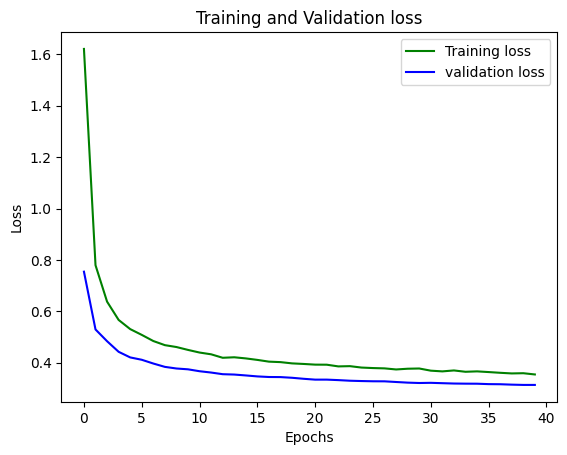

In [39]:
loss_val = history.history['val_loss']
loss_train = history.history['loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

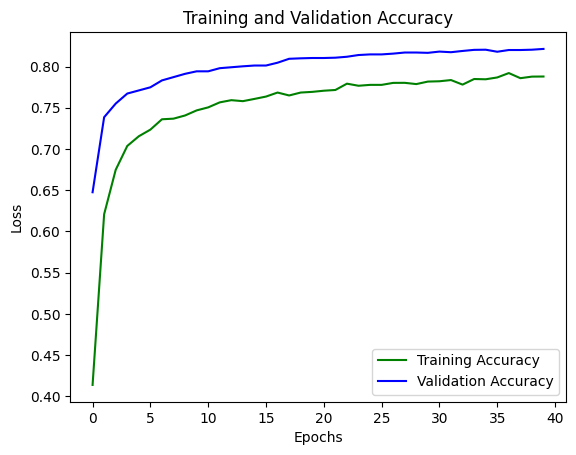

In [40]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
#model = keras.models.load_weights('multimodal_resNET50BERT_minority-3.h5')

In [36]:
multimodal_model.load_weights('multimodal_resNET50BERT_minority-5.h5')

In [42]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

465/465 [==============================] - 214s 460ms/step - loss: 0.3174 - accuracy: 0.8191
Accuracy on the test set: 81.91%.


In [37]:
class_names = list(label_map.keys())
def detailed_test_eval(model):
    prediction_labels = np.argmax(model.predict(test_ds), 1)
    print(classification_report(test_labels, prediction_labels, target_names=class_names))
    result = pd.DataFrame(confusion_matrix(test_labels, prediction_labels),
                        index=class_names, columns=class_names)
    result.to_csv('ETDSeg_confusion-matrix-4.csv')
    return result

In [38]:
detailed_test_eval(multimodal_model)

  1/465 [..............................] - ETA: 28:28

2023-06-01 10:29:54.728280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


465/465 [==============================] - 215s 455ms/step
                       precision    recall  f1-score   support

     Label-Appendices       0.78      0.91      0.84      1217
  Label-ReferenceList       0.92      0.94      0.93       485
          Label-Other       0.56      0.36      0.44       354
 Label-TableofContent       0.79      0.82      0.80       168
      Label-TitlePage       0.86      0.96      0.91       157
       Label-Abstract       0.65      0.47      0.54       164
  Label-ListofFigures       0.74      0.69      0.72       176
Label-Acknowledgement       0.92      0.87      0.90       163
   Label-ListofTables       0.83      0.57      0.67       166
Label-CurriculumVitae       0.97      0.98      0.97       297
     Label-Dedication       0.95      0.91      0.93       160
Label-ChapterAbstract       0.87      0.96      0.91       208

             accuracy                           0.82      3715
            macro avg       0.82      0.79      0.80     

,Label-Appendices,Label-ReferenceList,Label-Other,Label-TableofContent,Label-TitlePage,Label-Abstract,Label-ListofFigures,Label-Acknowledgement,Label-ListofTables,Label-CurriculumVitae,Label-Dedication,Label-ChapterAbstract
Label-Appendices,1103,20,50,6,3,18,3,3,6,2,2,1
Label-ReferenceList,22,454,3,0,1,0,0,0,0,1,4,0
Label-Other,142,17,128,6,18,17,10,4,5,7,0,0
Label-TableofContent,20,0,1,138,0,0,6,0,3,0,0,0
Label-TitlePage,4,0,2,0,151,0,0,0,0,0,0,0
Label-Abstract,33,0,25,0,2,77,0,0,0,0,0,27
Label-ListofFigures,33,0,2,14,0,0,122,0,5,0,0,0
Label-Acknowledgement,10,0,8,0,0,0,0,142,0,0,2,1
Label-ListofTables,36,0,2,11,0,0,23,0,94,0,0,0
Label-CurriculumVitae,0,2,4,0,0,0,0,1,0,290,0,0
